In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, logistic
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.preprocessing import *

import lightgbm as lgb
from lightgbm import LGBMClassifier
print(lgb.__version__)



4.5.0


In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [3]:
x = df.drop('mortality',axis=1)
y = df.mortality.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED)

#scaler = RobustScaler(unit_variance=True)
scaler = QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)
#scaler = PowerTransformer(method='yeo-johnson', standardize=True)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
lgbm_params = {
        'metric':['cross_entropy'],
        'objective': 'cross_entropy',
        'random_seed': 0,
        'force_col_wise': 'true',
        'is_unbalance':True,
        'data_sample_strategy':'bagging',
        'save_binary':True,
        'early_stopping_rounds' : 100,
        
}

def sigmoid(x):
  return 1/(1+np.exp(-x))

# Define the F1 Score metric
def f1_metric(y_true, y_pred):
  y_pred = (y_pred>=0.5).astype(int)
  f1 = f1_score(y_true, y_pred)
  return "f1", f1, True

params = {
    "objective": "binary",
    "metric": None,
    "verbosity": 1,
    "boosting_type": "dart",#"gbdt", #
    "is_unbalance": True,
    "num_boost_round": 1000,
    "early_stopping_round": 100,

    "max_depth" : 100,
    "num_leaves" : 10,
    "learning_rate" : 0.03,
    "min_data_in_leaf": 10,
    "bagging_fraction": 0.9,
    "feature_fraction": 0.9,
    "lambda_l1": 0,
    "lambda_l2": 2.,
    "min_split_gain": 0.1,
    "max_bin": 255,
    # dart param
    "drop_rate": 0.1,
    "max_drop": 50

}



In [15]:
eval_result = {}
record_evaluation_callback = lgb.callback.record_evaluation(eval_result =eval_result )

model = LGBMClassifier(**params)
model.fit(
    x_train, y_train,
    eval_set=[(x_test, y_test)],
    callbacks=[record_evaluation_callback],
    eval_metric=f1_metric
)

c:\Users\johne\anaconda3\envs\ml\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\johne\anaconda3\envs\ml\lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=2.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be 

LGBMClassifier(bagging_fraction=0.9, boosting_type='dart', drop_rate=0.1,
               early_stopping_round=100, feature_fraction=0.9,
               is_unbalance=True, lambda_l1=0, lambda_l2=2.0,
               learning_rate=0.03, max_bin=255, max_depth=100, max_drop=50,
               metric=None, min_data_in_leaf=10, min_split_gain=0.1,
               num_boost_round=10000, num_leaves=10, objective='binary',
               verbosity=1)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='f1'>

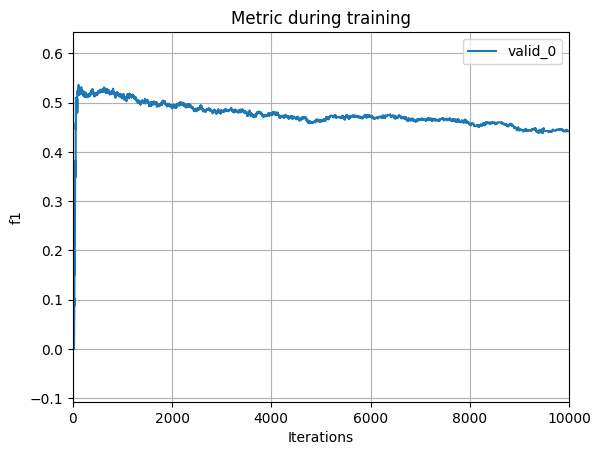

In [17]:
lgb.plot_metric(eval_result,metric='f1')

Accuracy: 0.743
Precision: 0.527
Recall: 0.381
F1 Score: 0.442
AUC score: 0.718 



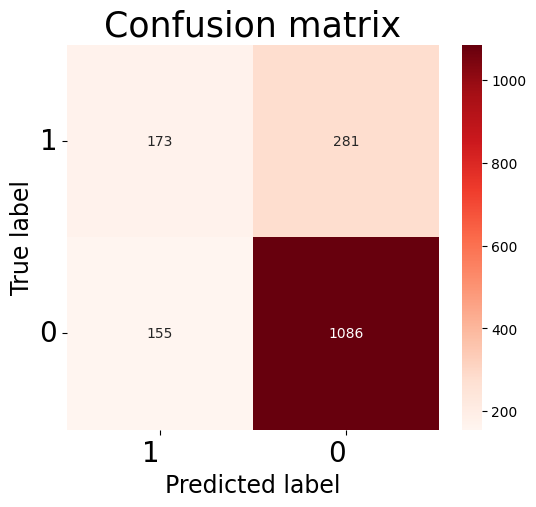

In [22]:
from util import *
p = model.predict_proba(x_test, verbosity=-1)[:,1]
y_label = model.predict(x_test, verbosity=-1)
evaluate_model(y_test, y_label, p)